# Time Series Prediction with LSTM Recurrent Neural Networks

Time series prediction problems are a difficult type of predictive modeling problem. Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables. A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory Networks or LSTM network is a type of recurrent neural network used in deep learning because very large
architectures can be successfully trained.

This lesson will show how to develop LSTM networks in Python using the Keras deep learning library to address a demonstration time series prediction problem. After completing this tutorial, you will know how to implement and develop LSTM networks for your own time
series prediction problems and other general sequence problems. You will know:

* How to develop LSTM networks for a time series prediction problem framed as regression.
* How to develop LSTM networks for a time series prediction problem using a window for both features and time steps.
* How to develop and make predictions using LSTM networks that maintain state (memory) across very long sequences.

We will develop a number of LSTMs for a standard time series prediction problem. The problem and the chosen configuration for the LSTM networks are for demonstration purposes only, they are not optimized. These examples will show you exactly how to develop your LSTM networks for time series predictive modeling problems. Let's get started.

## LSTM Network For Regression

The problem we are going to look at in this lesson is the international airline passengers prediction problem, described in previous lesson. We can phrase the problem as a regression problem, as was done in the previous lesson. Given the number of passengers (in units of thousands) this month, what is the number of passengers next month? This example will reuse the same data loading and preparation from the previous chapter, specifically using the `create_dataset()` function.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or Tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the `MinMaxScaler` preprocessing class from the scikit-learn library.

In [1]:
import os
import tensorflow as tf
import math

# Comment the next line if running on GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

'''
Uncomment this section if running on GPU
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)
assert tf.executing_eagerly()
'''
    
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataframe = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of [samples, time steps, features]. Our prepared data is in the form: [samples, features], and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using `numpy.reshape()` as follows:

In [2]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem. The network has a visible layer with one input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM memory blocks. The network is trained for 100 epochs, and a batch size of 1 is used.

In [3]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
94/94 - 1s - loss: 0.0521
Epoch 2/100
94/94 - 0s - loss: 0.0270
Epoch 3/100
94/94 - 0s - loss: 0.0207
Epoch 4/100
94/94 - 0s - loss: 0.0186
Epoch 5/100
94/94 - 0s - loss: 0.0176
Epoch 6/100
94/94 - 0s - loss: 0.0169
Epoch 7/100
94/94 - 0s - loss: 0.0158
Epoch 8/100
94/94 - 0s - loss: 0.0149
Epoch 9/100
94/94 - 0s - loss: 0.0141
Epoch 10/100
94/94 - 0s - loss: 0.0133
Epoch 11/100
94/94 - 0s - loss: 0.0123
Epoch 12/100
94/94 - 0s - loss: 0.0113
Epoch 13/100
94/94 - 0s - loss: 0.0104
Epoch 14/100
94/94 - 0s - loss: 0.0094
Epoch 15/100
94/94 - 0s - loss: 0.0085
Epoch 16/100
94/94 - 0s - loss: 0.0077
Epoch 17/100
94/94 - 0s - loss: 0.0067
Epoch 18/100
94/94 - 0s - loss: 0.0059
Epoch 19/100
94/94 - 0s - loss: 0.0052
Epoch 20/100
94/94 - 0s - loss: 0.0045
Epoch 21/100
94/94 - 0s - loss: 0.0039
Epoch 22/100
94/94 - 0s - loss: 0.0035
Epoch 23/100
94/94 - 0s - loss: 0.0031
Epoch 24/100
94/94 - 0s - loss: 0.0027
Epoch 25/100
94/94 - 0s - loss: 0.0025
Epoch 26/100
94/94 - 0s - loss: 0.

We can see that the model did an OK job of fitting both the training and the test datasets.

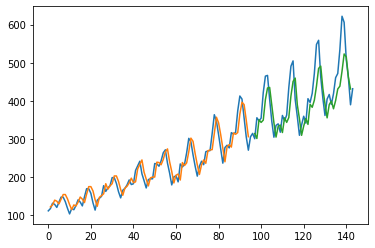

In [5]:
import matplotlib.pyplot as plt
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset and about 52 passengers (in thousands) on the test dataset. Not that bad.

## LSTM For Regression Using the Window Method

We can also phrase the problem so that multiple recent time steps can predict the next time step. This is called a window, and the window size is a parameter that can be tuned for each problem. For example, given the current time (t), we want to predict the value at the next time in the sequence (`t+1`), we can use the current time (`t`) as well as the two prior times (`t-1` and `t-2`) as input variables. When phrased as a regression problem, the input variables are `t-2`, `t-1`, `t`, and the output variable is `t+1`.

The create_dataset() function we created in the previous section allows us to create this time series problem by increasing the look back argument from 1 to 3. A sample of the dataset with this formulation looks as follows:

In [12]:
df = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
df = df.values
df = df.astype('float32')
x, y = create_dataset(df, look_back = 3)
df = pd.DataFrame(np.column_stack((x,y)), columns=['X1', 'X2', 'X3', 'Y'])
df.head()

,X1,X2,X3,Y
0,112.0,118.0,132.0,129.0
1,118.0,132.0,129.0,121.0
2,132.0,129.0,121.0,135.0
3,129.0,121.0,135.0,148.0
4,121.0,135.0,148.0,148.0


We can re-run the example in the previous section with the larger window size. Running the example provides the following output.

In [13]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
92/92 - 1s - loss: 0.0540
Epoch 2/100
92/92 - 0s - loss: 0.0249
Epoch 3/100
92/92 - 0s - loss: 0.0169
Epoch 4/100
92/92 - 0s - loss: 0.0144
Epoch 5/100
92/92 - 0s - loss: 0.0130
Epoch 6/100
92/92 - 0s - loss: 0.0116
Epoch 7/100
92/92 - 0s - loss: 0.0104
Epoch 8/100
92/92 - 0s - loss: 0.0092
Epoch 9/100
92/92 - 0s - loss: 0.0080
Epoch 10/100
92/92 - 0s - loss: 0.0070
Epoch 11/100
92/92 - 0s - loss: 0.0062
Epoch 12/100
92/92 - 0s - loss: 0.0055
Epoch 13/100
92/92 - 0s - loss: 0.0050
Epoch 14/100
92/92 - 0s - loss: 0.0046
Epoch 15/100
92/92 - 0s - loss: 0.0044
Epoch 16/100
92/92 - 0s - loss: 0.0042
Epoch 17/100
92/92 - 0s - loss: 0.0040
Epoch 18/100
92/92 - 0s - loss: 0.0039
Epoch 19/100
92/92 - 0s - loss: 0.0038
Epoch 20/100
92/92 - 0s - loss: 0.0037
Epoch 21/100
92/92 - 0s - loss: 0.0037
Epoch 22/100
92/92 - 0s - loss: 0.0037
Epoch 23/100
92/92 - 0s - loss: 0.0037
Epoch 24/100
92/92 - 0s - loss: 0.0036
Epoch 25/100
92/92 - 0s - loss: 0.0036
Epoch 26/100
92/92 - 0s - loss: 0.

We can see that the error was increased slightly compared to that of the previous section. The window size and the network architecture were not tuned; this is just a demonstration of framing a prediction problem.

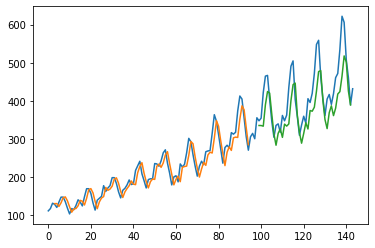

In [14]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## LSTM For Regression with Time Steps

You may have noticed that the data preparation for the LSTM network includes time steps. Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to the point of failure or a point of a surge. Each incident would be a sample; the observations that lead up to the event would be the time steps, and the variables observed would be the features. Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

In [22]:
dataframe = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is a more accurate framing of the problem. We can use the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the dimension of the feature back to 1. For example:

In [23]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

The entire code listing is provided below for completeness.

In [24]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
92/92 - 1s - loss: 0.0515
Epoch 2/100
92/92 - 0s - loss: 0.0205
Epoch 3/100
92/92 - 0s - loss: 0.0169
Epoch 4/100
92/92 - 0s - loss: 0.0145
Epoch 5/100
92/92 - 0s - loss: 0.0124
Epoch 6/100
92/92 - 0s - loss: 0.0105
Epoch 7/100
92/92 - 0s - loss: 0.0087
Epoch 8/100
92/92 - 0s - loss: 0.0074
Epoch 9/100
92/92 - 0s - loss: 0.0064
Epoch 10/100
92/92 - 0s - loss: 0.0055
Epoch 11/100
92/92 - 0s - loss: 0.0051
Epoch 12/100
92/92 - 0s - loss: 0.0049
Epoch 13/100
92/92 - 0s - loss: 0.0046
Epoch 14/100
92/92 - 0s - loss: 0.0049
Epoch 15/100
92/92 - 0s - loss: 0.0045
Epoch 16/100
92/92 - 0s - loss: 0.0045
Epoch 17/100
92/92 - 0s - loss: 0.0045
Epoch 18/100
92/92 - 0s - loss: 0.0045
Epoch 19/100
92/92 - 0s - loss: 0.0044
Epoch 20/100
92/92 - 0s - loss: 0.0043
Epoch 21/100
92/92 - 0s - loss: 0.0047
Epoch 22/100
92/92 - 0s - loss: 0.0044
Epoch 23/100
92/92 - 0s - loss: 0.0043
Epoch 24/100
92/92 - 0s - loss: 0.0043
Epoch 25/100
92/92 - 0s - loss: 0.0043
Epoch 26/100
92/92 - 0s - loss: 0.

We can see that the results are slightly better than the previous example, and the structure of the input data makes a lot more sense.

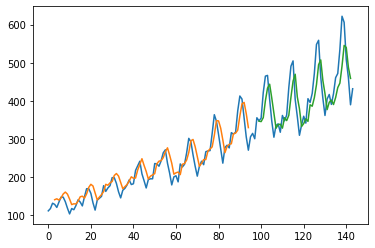

In [25]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## LSTM With Memory Between Batches

The LSTM network has a memory that is capable of remembering across long sequences. Normally, the state within the network is reset after each training batch when fitting the model and each call to `model.predict()` or `model.evaluate()`. We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer stateful. This means that it can build a state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to `model.reset_states()`. This means that we must create our own outer loop of epochs and within each epoch call `model.fit()` and `model.reset_states()`, for example:

```
for i in range(100):
    model.fit(trainX, 
              trainY, 
              epochs=1, 
              batch_size=batch_size, 
              verbose=2, s
              huffle=False)
    model.reset_states()
```

Finally, when the LSTM layer is constructed, the stateful parameter must be set to True, and instead of specifying the input dimensions, we must hard code the number of samples in a batch, the number of time steps in a sample, and the number of features in a time step by setting the batch input shape parameter. For example:

```
model.add(LSTM(4, 
               batch_input_shape=(batch_size, time_steps, features), 
               stateful=True)
         )
```

This same batch size must then be used later when evaluating the model and making predictions. For example:

`model.predict(trainX, batch_size=batch_size)`

We can adapt the previous time step example to use a stateful LSTM. The complete code listing is provided below.

In [28]:
dataframe = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

92/92 - 1s - loss: 0.0067
92/92 - 0s - loss: 0.0250
92/92 - 0s - loss: 0.0128
92/92 - 0s - loss: 0.0084
92/92 - 0s - loss: 0.0066
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0042
92/92 - 0s - loss: 0.0042
92/92 - 0s - loss: 0.0042
92/92 - 0s - loss: 0.0041
92/92 - 0s - loss: 0.0041
92/92 - 0s - loss: 0.0041
92/92 - 0s - loss: 0.0040
92/92 - 0s - loss: 0.0040
92/92 - 0s - loss: 0.0040
92/92 - 0s - loss: 0.0039
92/92 - 0s - loss: 0.0039
92/92 - 0s -

We do see that results are better than some, worse than others. The model may need more modules and may need to be trained for more epochs to internalize the structure of the problem.

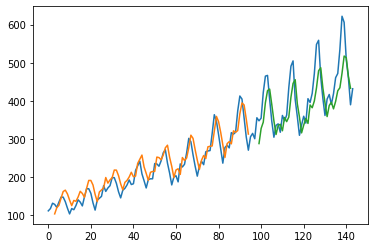

In [29]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stacked LSTMs With Memory Between Batches

Finally, we will take a look at one of the big benefits of LSTMs, the fact that they can be successfully trained when stacked into deep network architectures. LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the required configuration is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return sequences parameter on the layer to True. We can extend the stateful LSTM in the previous section to have two layers, as follows:

```
model.add(LSTM(4, 
               batch_input_shape=(batch_size, look_back, 1), 
               stateful=True, 
               return_sequences=True)
         )
model.add(LSTM(4, 
               batch_input_shape=(batch_size, look_back, 1), 
               stateful=True)
         )
```

The entire code listing is provided below for completeness.

In [30]:
dataframe = pd.read_csv('../../datasets/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True,
return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

92/92 - 1s - loss: 0.0051
92/92 - 0s - loss: 0.0162
92/92 - 0s - loss: 0.0081
92/92 - 0s - loss: 0.0066
92/92 - 0s - loss: 0.0061
92/92 - 0s - loss: 0.0060
92/92 - 0s - loss: 0.0059
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s -

The predictions on the test dataset are again worse. This is more evidence to suggest the need for additional training epochs.

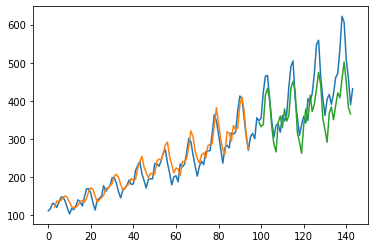

In [31]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Summary

In this lesson, you discovered how to develop LSTM recurrent neural networks for time series prediction in Python with the Keras deep learning network. Specifically, you learned: 

* How to create an LSTM for regression and a window formulation of the time series problem.
* How to create an LSTM with a time step formulation of the time series problem.
* How to create an LSTM with state and stacked LSTMs with state to learn long sequences.